In [400]:
mod = xgb_model(num_boost_round=100, max_depth=20, eta=0.1, gpu_id=0, tree_method='gpu_hist')
xgb1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
xgb1.scores

Working on: 2015-07
fit time: 674.1133131980896
Working on: 2015-08
fit time: 763.0178606510162
Working on: 2015-09
fit time: 729.9509105682373


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.353711,1.603867,1.209186,1.625746
2015-08,1.348747,1.627739,4.470294,6.212531
2015-09,1.312563,1.601965,3.394250,4.365873
FINAL,1.188368,1.465455,NaN,NaN


# Ensembling work

Collect predictions

In [193]:
keys = list(xgb1.fitted_models.keys())

In [199]:
%%time
preds = {}
for key in keys[:-1]:
    Xtest, Ytest, Ytest_sub = get_single_month_XY(key)
    Ypred = xgb1.fitted_models[key].predict(Xtest)
    Ypred_sub = conform_to_subY(Xtest, Ypred, Ytest_sub)
    preds[key] = Ypred_sub

Wall time: 1min 19s


In [206]:
Xtest, Ytest, _ = get_single_month_XY(months[-1])
Ypred = xgb1.fitted_models['FINAL'].predict(Xtest)
Ypred = pd.Series(Ypred, index=Xtest.index)

In [211]:
test_copy = test_set.copy()
test_copy['Period'] = months[-1]
preds[months[-1]] = Ypred.reindex(test_copy.set_index(['Period','shop_id','item_id']).index).fillna(0)

In [273]:
model2_oos_predictions = pd.DataFrame(pd.concat(preds).reset_index(level=0, drop=True).rename('Pred2'))
model2_oos_predictions = model2_oos_predictions.reset_index()

In [274]:
obj_month_map = dict(zip(months, months[1:]+[pd.Period('2015-11')]))

In [275]:
model2_oos_predictions['Period'] = model2_oos_predictions['Period'].map(obj_month_map)
model2_oos_predictions = model2_oos_predictions.rename(columns={'Period': 'Month'}).set_index(['Month', 'shop_id', 'item_id']).sort_index()

In [ ]:
# model2_oos_predictions.to_csv('model2_oos_preds.csv')
# model2_oos_predictions.to_pickle('model2_oos_preds.p')

In [56]:
model2_oos_predictions = pd.read_pickle('model2_oos_preds.p')

In [142]:
get_error(model2_oos_predictions.Pred2, submission_like_df.item_cnt_month)

2015-02    0.730089
2015-03    0.836271
2015-04    3.679942
2015-05    2.069079
2015-06    0.680194
2015-07    0.486832
2015-08    0.591085
2015-09    0.916012
2015-10    0.781028
Freq: M, dtype: float64

In [143]:
get_error(model2_oos_predictions.Pred2.clip(0,20), submission_like_df.item_cnt_month)

2015-02    1.398093
2015-03    1.383413
2015-04    4.283555
2015-05    3.516500
2015-06    1.952567
2015-07    1.772694
2015-08    1.838626
2015-09    6.580991
2015-10    5.097406
Freq: M, dtype: float64

In [38]:
get_error(model2_oos_predictions.Pred2.clip(0,20), submission_like_df.item_cnt_month)

2015-02    1.398093
2015-03    1.383413
2015-04    4.283555
2015-05    3.516500
2015-06    1.952567
2015-07    1.772694
2015-08    1.838626
2015-09    6.580991
2015-10    5.097406
Freq: M, dtype: float64

# Ensembling

In [144]:
feb15 = pd.Period('2015-02')

In [145]:
%%time
ensembling_preds = pd.concat([model1_oos_predictions.loc[feb15:], model2_oos_predictions], axis=1)
ensembling_preds.index = ensembling_preds.index.remove_unused_levels()

Wall time: 2.76 s


In [146]:
get_error(ensembling_preds.Pred2, submission_like_df.item_cnt_month)

2015-02    0.730089
2015-03    0.836271
2015-04    3.679942
2015-05    2.069079
2015-06    0.680194
2015-07    0.486832
2015-08    0.591085
2015-09    0.916012
2015-10    0.781028
Freq: M, dtype: float64

In [147]:
get_error(ensembling_preds.Pred1, submission_like_df.item_cnt_month)

2015-02    3.323760
2015-03    2.173922
2015-04    4.389656
2015-05    3.368271
2015-06    1.689504
2015-07    1.051905
2015-08    1.276000
2015-09    6.448826
2015-10    4.541086
Freq: M, dtype: float64

In [184]:
ensembling_errors = {}
for alpha in np.linspace(0,1,11):
    y1 = ensembling_preds.Pred1*alpha
    y2 = ensembling_preds.Pred2*(1-alpha)
    ypred = y1 + y2
    rmse = {}
    ensembling_errors[alpha] = get_error(ypred, submission_like_df.item_cnt_month)    

0.0 630634.56 630634.5387015045
55150.357652509745 567571.1 622721.4278793475
110300.71530501949 504507.53 614808.3548143286
165451.0729575293 441444.06 606895.2433242139
220601.43061003898 378380.97 598982.1691587783
275751.7882625488 315317.28 591069.0576133011
330902.1459150586 252253.77 583155.9656697131
386052.50356756884 189190.48 575242.8728419382
441202.86122007796 126126.88 567329.7710974053
496353.21887258784 63063.44 559416.673811251
551503.5765250976 0.0 551503.5765250976


In [185]:
pd.concat(ensembling_errors, axis=1)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
2015-02,0.730089,0.808959,0.991199,1.231753,1.502875,1.790734,2.088421,2.392270,2.700201,3.010962,3.323760
2015-03,0.836271,0.870167,0.944277,1.050120,1.179183,1.324696,1.481820,1.647236,1.818684,1.994608,2.173922
2015-04,3.679942,3.708544,3.747657,3.796955,3.856050,3.924497,4.001817,4.087507,4.181052,4.281936,4.389656
2015-05,2.069079,2.108778,2.175529,2.266943,2.380181,2.512293,2.660468,2.822179,2.995233,3.177778,3.368271
2015-06,0.680194,0.706784,0.762482,0.841527,0.938036,1.047191,1.165445,1.290299,1.420012,1.553368,1.689504
2015-07,0.486832,0.507419,0.541033,0.585434,0.638375,0.697915,0.762511,0.830983,0.902450,0.976255,1.051905
2015-08,0.591085,0.614610,0.654389,0.707685,0.771704,0.844008,0.922652,1.006150,1.093390,1.183547,1.276000
2015-09,0.916012,1.149043,1.612483,2.162980,2.748716,3.351265,3.962966,4.580152,5.200872,5.823995,6.448826
2015-10,0.781028,0.954018,1.260275,1.626173,2.019550,2.427082,2.842688,3.263284,3.687162,4.113309,4.541086


In [186]:
ensembling_errors = {}
for alpha in np.linspace(0,1,11):
    y1 = (ensembling_preds.Pred1*alpha).clip(0,20)
    y2 = (ensembling_preds.Pred2*(1-alpha)).clip(0,20)
    ypred = y1 + y2
    rmse = {}
    ensembling_errors[alpha] = get_error(ypred, submission_like_df.item_cnt_month)    

In [187]:
pd.concat(ensembling_errors, axis=1)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
2015-02,1.398093,1.291655,1.283838,1.312344,1.354772,1.406427,1.466465,1.535027,1.618127,1.726074,1.866527
2015-03,1.383413,1.326289,1.303098,1.301350,1.310171,1.327345,1.349269,1.376163,1.417565,1.483023,1.593579
2015-04,4.283555,4.248676,4.241189,4.247414,4.259812,4.275784,4.294376,4.319241,4.351542,4.399019,4.494598
2015-05,3.516500,3.427689,3.425759,3.433243,3.443992,3.456068,3.470172,3.487669,3.512128,3.552227,3.679940
2015-06,1.952567,1.836252,1.822722,1.824395,1.832513,1.843490,1.858044,1.877907,1.905605,1.945858,2.082457
2015-07,1.772694,1.666968,1.652877,1.652776,1.660306,1.671594,1.686075,1.704619,1.731901,1.775741,1.901280
2015-08,1.838626,1.740962,1.724023,1.716241,1.720874,1.731365,1.746843,1.766449,1.797037,1.851007,1.991867
2015-09,6.580991,6.540365,6.526896,6.517906,6.512797,6.512825,6.516079,6.521631,6.531341,6.549699,6.709810
2015-10,5.097406,5.024416,5.018724,5.018010,5.022232,5.029541,5.040473,5.055123,5.076927,5.109416,5.218142


In [188]:
alpha = 0.3
y1 = (ensembling_preds.Pred1*alpha).clip(0,20)
y2 = (ensembling_preds.Pred2*(1-alpha)).clip(0,20)
ypred = y1 + y2

In [ ]:
ypred.loc[pd.Period('2015-11')]

Other models

### Random Forrest

In [50]:
mod = RandomForestRegressor(n_estimators=5, max_depth=3, n_jobs=-1)
res11 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res11.scores

Working on: 2015-02
fit time: 157.65510964393616
Working on: 2015-03
fit time: 167.13195729255676
Working on: 2015-04
fit time: 162.0644872188568
Working on: 2015-05
fit time: 166.44589352607727
Working on: 2015-06
fit time: 157.0563473701477
Working on: 2015-07
fit time: 161.12535333633423
Working on: 2015-08
fit time: 167.23387360572815
Working on: 2015-09
fit time: 176.44227600097656


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,2.014472,2.292852,2.153181,2.631210
2015-03,1.988152,2.278655,3.323835,4.257576
2015-04,2.103979,2.439763,2.359528,3.142759
2015-05,2.178823,2.557594,1.019679,1.318083
2015-06,2.132482,2.536802,0.873650,1.108336
2015-07,2.135277,2.582634,1.087771,1.403946
2015-08,2.125936,2.612057,4.630965,6.445904
2015-09,2.369354,2.950731,3.557495,4.639217
FINAL,NaN,2.337687,NaN,NaN


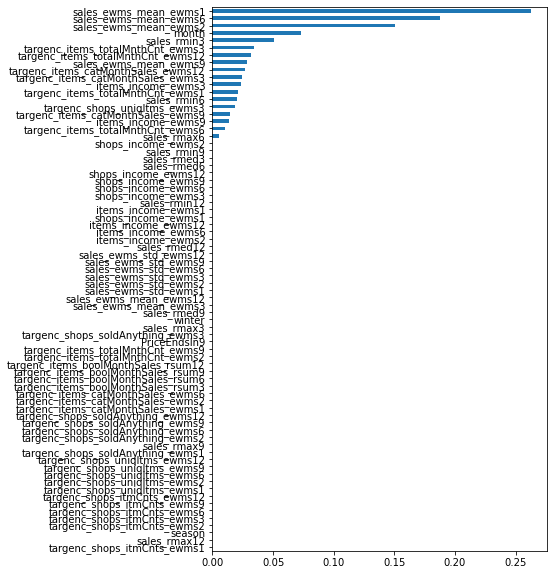

In [51]:
plot_feature_importances(res11.fitted_models['FINAL'])

In [103]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
res5 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res5.scores

Working on: 2015-02
fit time: 1519.3715209960938
Working on: 2015-03
fit time: 1535.786041021347
Working on: 2015-04
fit time: 1463.752594947815
Working on: 2015-05
fit time: 1471.0660820007324
Working on: 2015-06
fit time: 1479.5447058677673
Working on: 2015-07
fit time: 1514.2314159870148
Working on: 2015-08
fit time: 1505.886890888214
Working on: 2015-09
fit time: 1483.0496306419373


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.791767,2.035318,2.021579,2.465638
2015-03,1.764429,2.025564,3.324435,4.220675
2015-04,1.901200,2.201253,2.345511,3.056807
2015-05,1.968547,2.309693,1.142206,1.488297
2015-06,1.951029,2.322303,0.801220,1.066336
2015-07,1.943119,2.349970,0.986363,1.301993
2015-08,1.931048,2.369730,4.557945,6.345695
2015-09,2.017162,2.513729,3.588552,4.623948
FINAL,NaN,1.966828,NaN,NaN


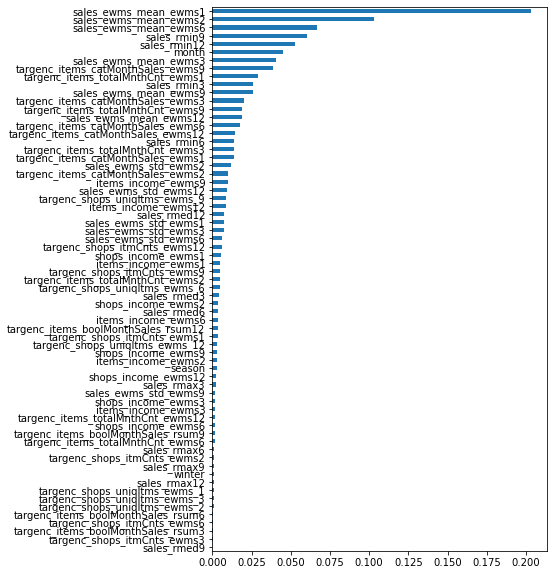

In [104]:
plot_feature_importances(res5.fitted_models['FINAL'])

### Linear Model

In [59]:
mod = LinearRegression()
res6 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res6.scores

Working on: 2015-02
fit time: 65.78097200393677
Working on: 2015-03
fit time: 54.72403526306152
Working on: 2015-04
fit time: 67.39345169067383
Working on: 2015-05
fit time: 69.66224312782288
Working on: 2015-06
fit time: 63.36846327781677
Working on: 2015-07
fit time: 58.59580135345459
Working on: 2015-08
fit time: 72.33271074295044
Working on: 2015-09
fit time: 73.44256091117859


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,2.025938,2.312923,1.540135,1.862554
2015-03,2.009423,2.311610,3.437756,4.396273
2015-04,2.144183,2.493302,2.456698,3.252347
2015-05,2.211525,2.605925,1.119091,1.436054
2015-06,2.201265,2.630486,0.753052,0.965527
2015-07,2.189368,2.654347,0.929130,1.194665
2015-08,2.182389,2.687475,4.601868,6.404143
2015-09,2.447985,3.058120,3.768735,4.639154
FINAL,NaN,2.557398,NaN,NaN


In [60]:
res6.fitted_models['FINAL'].coef_

array([ 3.12574273e+00, -1.75789875e+01,  3.13284334e+01, -4.30184668e+01,
        4.57600290e+01, -1.81711770e+01, -6.86776623e-01,  5.97470903e+00,
       -1.91067922e+01,  6.53419483e+01, -1.07164011e+02,  5.51536610e+01,
       -1.88443690e-05,  1.25016372e-04, -2.09950996e-04,  3.05900372e-04,
       -3.37809208e-04,  1.35138353e-04,  4.35773195e-07, -1.96074045e-06,
        2.25377399e-06, -5.30107211e-07, -3.08494377e-06,  2.87819596e-06,
       -3.77551385e-02, -3.77551230e-02, -3.77551372e-02, -3.77551324e-02,
       -2.69782901e-02, -2.69782920e-02, -2.69782805e-02, -2.69782847e-02,
       -1.62014577e-02, -1.62014613e-02, -1.62014612e-02, -1.62014613e-02,
       -1.19651198e-03,  9.95776028e-03, -2.17316180e-02,  5.32102154e-02,
       -7.67922067e-02,  3.66218938e-02,  3.42097840e-03, -3.15958923e-02,
        7.03021668e-02, -1.70186007e-01,  2.49755211e-01, -1.21724269e-01,
       -1.25173120e-04,  1.27107704e-03, -2.19753938e-03,  1.60137919e-03,
        1.85096965e-04, -

Parameter hypertuning:
- num_boost_rounds: 10 - 500
- max_depth: 5 - 30
- eta : 0.5 - 0.01